In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re



In [2]:
np.load("aggregated_results/input_dim_2_False_adam.npy", allow_pickle=True).item()['model_0_perturbations'].mean()


0.4672052

In [3]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re

def load_all_aggregated_data() -> dict:
    """Load all aggregated data for various configurations: input dimensions, pseudo rehearsal, and optimizer.
    
    Returns:
    - all_data (dict): A nested dictionary with keys as input dimensions, pseudorehearsal, and optimizer 
                       and values as the loaded data.
    """
    all_data = {}
    save_folder = "aggregated_results"
    
    # Get all files in the folder with the .npy extension
    files = [f for f in os.listdir(save_folder) if f.endswith(".npy")]

    # Extract the configuration details from the file name using regex
    pattern = re.compile(r"input_dim_(\d+)_(True|False)_(\w+).npy")

    for file in files:
        match = pattern.match(file)
        if match:
            dim = int(match.group(1))
            pseudo_rehearsal = True if match.group(2) == 'True' else False
            optimizer = match.group(3)
            
            if dim not in all_data:
                all_data[dim] = {}
            
            if pseudo_rehearsal not in all_data[dim]:
                all_data[dim][pseudo_rehearsal] = {}
            
            save_path = os.path.join(save_folder, file)
            data = np.load(save_path, allow_pickle=True).item()
            all_data[dim][pseudo_rehearsal][optimizer] = data

    return all_data 

def get_perturbation_labels(output_dim: int = 1,
                            hidden_units_wide: int = 1000,
                            hidden_units_deep: int = 16,
                            hidden_layers: int = 8,
                            num_exps: int = 6) -> dict:
    """Generate dictionary of perturbation labels with given configurations."""
    
    model_descriptions = [
        'Linear Model',
        f"Wide ReLU ANN",
        f"Deep ReLU ANN",
        'One Parameter'
    ]

    for partition_num in [1, 2, 4, 8, 10]:
        model_descriptions.extend([
            f"Spline ANN (z={partition_num})",
            f"Lookup Table (z={partition_num})",
            f"ABEL-Spline (z={partition_num})"
        ])

    # Model perturbation labels
    perturbation_labels = {f"model_{i}_perturbations": desc for i, desc in enumerate(model_descriptions)}
    
    # Adding the distance labels
    perturbation_labels["min_distance"] = "Min Absolute Difference"
    perturbation_labels["max_distance"] = "Max Absolute Difference"

    return perturbation_labels

def create_nested_dataframe_dict(loaded_data_dict: dict) -> dict:
    """Create a nested dictionary of pandas DataFrames using loaded data."""
    return {
        dim: {
            pseudo: {
                optimizer: pd.DataFrame(data)
                for optimizer, data in optimizer_data.items()
            }
            for pseudo, optimizer_data in pseudo_rehearsal_data.items()
        }
        for dim, pseudo_rehearsal_data in loaded_data_dict.items()
    }


# Example usage:
perturbation_labels_dict = get_perturbation_labels()
for key, value in perturbation_labels_dict.items():
    print(f"{key} -> {value}")

# Example usage:
perturb_data_dict = load_all_aggregated_data()
#for dim, pseudo_rehearsal_data in loaded_data_dict.items():
#    for pseudo, optimizer_data in pseudo_rehearsal_data.items():
#        for optimizer, data in optimizer_data.items():
#            print(f"Data for dimension {dim}, pseudorehearsal: {pseudo}, 
# optimizer: {optimizer} has keys: \n\n {data.keys()} \n\n")

# Example usage:
#df_dict = create_nested_dataframe_dict(loaded_data_dict)

model_0_perturbations -> Linear Model
model_1_perturbations -> Wide ReLU ANN
model_2_perturbations -> Deep ReLU ANN
model_3_perturbations -> One Parameter
model_4_perturbations -> Spline ANN (z=1)
model_5_perturbations -> Lookup Table (z=1)
model_6_perturbations -> ABEL-Spline (z=1)
model_7_perturbations -> Spline ANN (z=2)
model_8_perturbations -> Lookup Table (z=2)
model_9_perturbations -> ABEL-Spline (z=2)
model_10_perturbations -> Spline ANN (z=4)
model_11_perturbations -> Lookup Table (z=4)
model_12_perturbations -> ABEL-Spline (z=4)
model_13_perturbations -> Spline ANN (z=8)
model_14_perturbations -> Lookup Table (z=8)
model_15_perturbations -> ABEL-Spline (z=8)
model_16_perturbations -> Spline ANN (z=10)
model_17_perturbations -> Lookup Table (z=10)
model_18_perturbations -> ABEL-Spline (z=10)
min_distance -> Min Absolute Difference
max_distance -> Max Absolute Difference


In [4]:
perturb_data_dict[1][False]['adam']['model_0_perturbations']

array([0.65062225, 0.21534252, 0.52328193, ..., 0.30434477, 0.25704533,
       0.14038728], dtype=float32)

In [5]:
import numpy as np

# Initialize the means_stds dictionary
means_stds = {}

# Iterate over dimensions, pseudo-rehearsal status, optimizer type and model perturbations
for dim in perturb_data_dict.keys():
    for pseudo_rehearsal_status in perturb_data_dict[dim].keys():
        for optimizer_type in perturb_data_dict[dim][pseudo_rehearsal_status].keys():
            for model_perturbation in perturb_data_dict[dim][pseudo_rehearsal_status][optimizer_type].keys():

                # Formulate dataset name
                pseudo_rehearsal_string = 'Pseudo-Rehearsal' if pseudo_rehearsal_status else 'No Pseudo-Rehearsal'
                dataset_name = f"{optimizer_type.upper()} with {pseudo_rehearsal_string} in {dim}D"
                if dataset_name not in means_stds:
                    means_stds[dataset_name] = {}

                # Get the model name from the label dictionary
                model_name = perturbation_labels_dict[model_perturbation]
                if model_name not in means_stds[dataset_name]:
                    means_stds[dataset_name][model_name] = {}
                
                # Compute mean and standard deviation of the numpy array
                data_array = perturb_data_dict[dim][pseudo_rehearsal_status][optimizer_type][model_perturbation]
                mean_metric = np.mean(data_array)
                std_metric = np.std(data_array)

                # Save them into the dictionary
                means_stds[dataset_name][model_name]['mean'] = mean_metric
                means_stds[dataset_name][model_name]['std'] = std_metric

In [6]:
import numpy as np

# Initialize the means_stds dictionary
means_stds = {}

# Iterate over pseudo-rehearsal status, optimizer type and dimensions
for pseudo_rehearsal_status in [True, False]:
    for optimizer_type in ['adam', 'sgd']:
        for dim in range(1, 7):
            if dim not in perturb_data_dict:
                continue

            # Formulate dataset name
            pseudo_rehearsal_string = 'Pseudo-Rehearsal' if pseudo_rehearsal_status else 'No Pseudo-Rehearsal'
            dataset_name = f"{optimizer_type.upper()} with {pseudo_rehearsal_string} in {dim}D"
            
            if dataset_name not in means_stds:
                means_stds[dataset_name] = {}

            for model_perturbation in perturb_data_dict[dim][pseudo_rehearsal_status][optimizer_type].keys():
                
                # Get the model name from the label dictionary
                model_name = perturbation_labels_dict[model_perturbation]
                if model_name not in means_stds[dataset_name]:
                    means_stds[dataset_name][model_name] = {}
                
                # Compute mean and standard deviation of the numpy array
                data_array = perturb_data_dict[dim][pseudo_rehearsal_status][optimizer_type][model_perturbation]
                mean_metric = np.mean(data_array)
                std_metric = np.std(data_array)

                # Save them into the dictionary
                means_stds[dataset_name][model_name]['mean'] = mean_metric
                means_stds[dataset_name][model_name]['std'] = std_metric

In [7]:
list(means_stds.keys())

['ADAM with Pseudo-Rehearsal in 1D',
 'ADAM with Pseudo-Rehearsal in 2D',
 'ADAM with Pseudo-Rehearsal in 3D',
 'ADAM with Pseudo-Rehearsal in 4D',
 'ADAM with Pseudo-Rehearsal in 5D',
 'ADAM with Pseudo-Rehearsal in 6D',
 'SGD with Pseudo-Rehearsal in 1D',
 'SGD with Pseudo-Rehearsal in 2D',
 'SGD with Pseudo-Rehearsal in 3D',
 'SGD with Pseudo-Rehearsal in 4D',
 'SGD with Pseudo-Rehearsal in 5D',
 'SGD with Pseudo-Rehearsal in 6D',
 'ADAM with No Pseudo-Rehearsal in 1D',
 'ADAM with No Pseudo-Rehearsal in 2D',
 'ADAM with No Pseudo-Rehearsal in 3D',
 'ADAM with No Pseudo-Rehearsal in 4D',
 'ADAM with No Pseudo-Rehearsal in 5D',
 'ADAM with No Pseudo-Rehearsal in 6D',
 'SGD with No Pseudo-Rehearsal in 1D',
 'SGD with No Pseudo-Rehearsal in 2D',
 'SGD with No Pseudo-Rehearsal in 3D',
 'SGD with No Pseudo-Rehearsal in 4D',
 'SGD with No Pseudo-Rehearsal in 5D',
 'SGD with No Pseudo-Rehearsal in 6D']

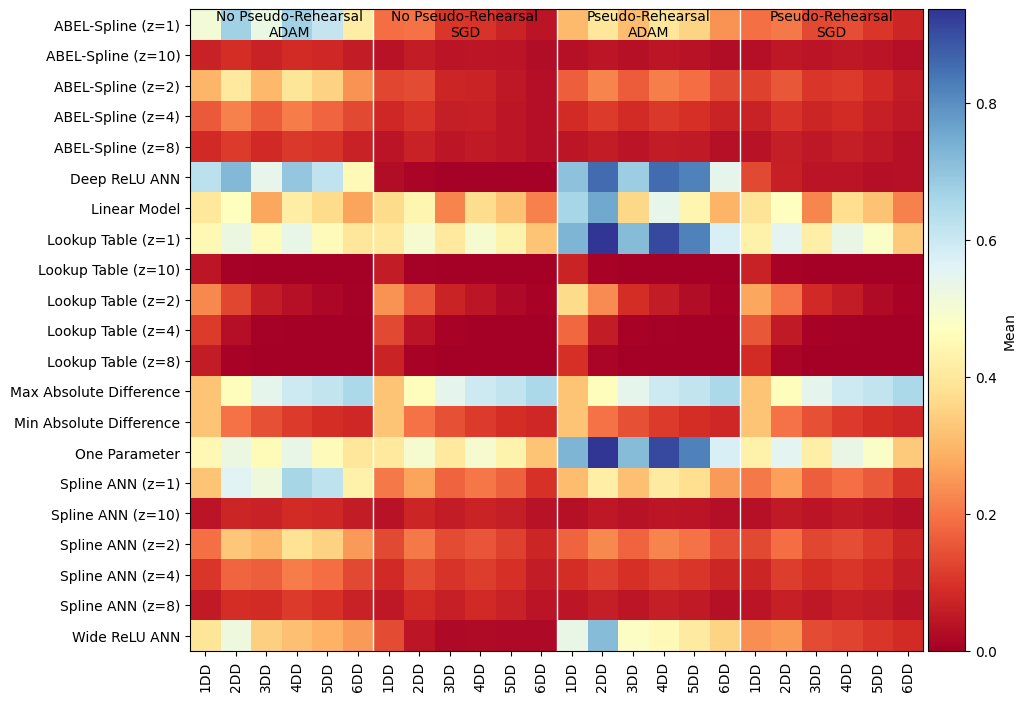

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_means():
    # Get unique model names and dataset names from means_stds dictionary
    model_names = sorted(set([model for dataset in means_stds.values() for model in dataset.keys()]))
    dataset_names = sorted(means_stds.keys())

    data_array = np.zeros((len(model_names), len(dataset_names)))

    # Fill data_array with mean values from means_stds dictionary
    for i, model_name in enumerate(model_names):
        for j, dataset_name in enumerate(dataset_names):
            if model_name in means_stds[dataset_name]:
                data_array[i, j] = means_stds[dataset_name][model_name]['mean']

    fig, ax = plt.subplots(figsize=(10, len(model_names)/2))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    im = ax.imshow(data_array, interpolation='nearest', cmap='RdYlBu')

    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.set_label('Mean', rotation=90) 

    ax.set_yticks(np.arange(len(model_names)))
    ax.set_yticklabels(model_names)

    ax.set_xticks(np.arange(len(dataset_names)))
    
     # Grouping headers by experiment type
    group_labels = ["No Pseudo-Rehearsal\nADAM", "No Pseudo-Rehearsal\nSGD", "Pseudo-Rehearsal\nADAM", "Pseudo-Rehearsal\nSGD"]
    group_boundaries = [0] + [i+0.5 for i in range(5, len(dataset_names), 6)] + [len(dataset_names)]
    for i, label in enumerate(group_labels):
        ax.text((group_boundaries[i] + group_boundaries[i+1]) / 2, -0.5, label,
                  horizontalalignment='center', verticalalignment='top')
        if i > 0:
             ax.axvline(x=group_boundaries[i], color='white', linewidth=1)
    
    ax.set_xticklabels([f"{name.split()[-1]}D" for name in dataset_names], rotation=90)

    #plt.savefig('mean_metric.png', dpi=300, bbox_inches='tight')
    #plt.close(fig)  
    plt.show()

# Call the function to create and save the plot
plot_means()

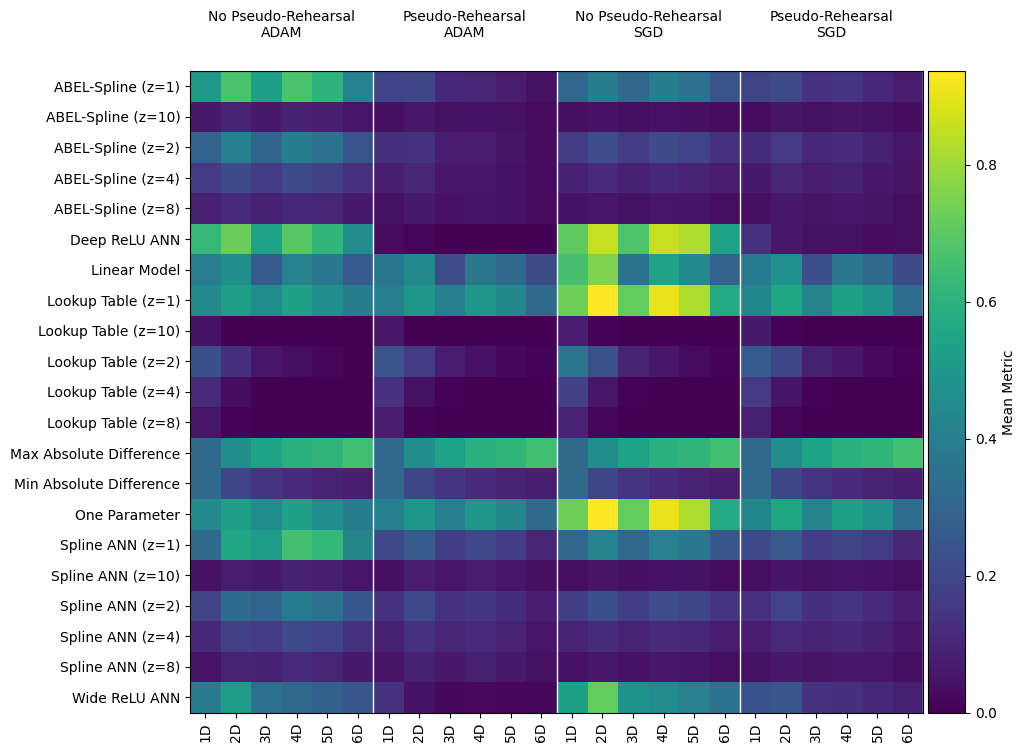

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# List of model names in the order you want them to appear on the y-axis
model_names = list(perturbation_labels_dict.values())
model_names.sort()  # Sort them alphabetically for example

# List of optimizer types and pseudo rehearsal statuses to iterate over when filling data array
optimizer_types = ['adam', 'sgd']
pseudo_rehearsal_statuses = [False, True]

# Initialize 2D numpy array to hold mean values
data_array = np.zeros((len(model_names), len(optimizer_types) * len(pseudo_rehearsal_statuses) * 6))  # 6 for dimensions from 1 to 6

# Fill data array with mean values
for i, model_name in enumerate(model_names):
    for j, (opt_type, pseudo_status) in enumerate([(opt_type, pseudo_status) for opt_type in optimizer_types for pseudo_status in pseudo_rehearsal_statuses]):
        for dim in range(1, 7):
            dataset_name = f"{opt_type.upper()} with {'Pseudo-Rehearsal' if pseudo_status else 'No Pseudo-Rehearsal'} in {dim}D"
            if dataset_name in means_stds and model_name in means_stds[dataset_name]:
                data_array[i, j * 6 + dim - 1] = means_stds[dataset_name][model_name]['mean']

# Create 2D imshow plot with colorbar
fig, ax = plt.subplots(figsize=(10, len(model_names)/2))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(data_array, interpolation='nearest', cmap='viridis')
cbar = fig.colorbar(im, cax=cax, orientation="vertical")

# Add label to colorbar
cbar.set_label("Mean Metric", rotation=90)

# Set model names as y tick labels
ax.set_yticks(np.arange(len(model_names)))
ax.set_yticklabels(model_names)

# Set x tick labels and draw white lines to separate different groups
x_tick_labels = []
for j, (opt_type, pseudo_status) in enumerate([(opt_type, pseudo_status) for opt_type in optimizer_types for pseudo_status in pseudo_rehearsal_statuses]):
    for dim in range(1, 7):
        x_tick_labels.append(f"{dim}D")
    ax.axvline(x=(j+1)*6 - 0.5, color='white', linewidth=1)
ax.set_xticks(np.arange(len(x_tick_labels)))
ax.set_xticklabels(x_tick_labels, rotation=90)

# Add text above each group of datasets indicating optimizer type and pseudo rehearsal status
for j, (opt_type, pseudo_status) in enumerate([(opt_type, pseudo_status) for opt_type in optimizer_types for pseudo_status in pseudo_rehearsal_statuses]):
    ax.text(j * 6 + 2.5, -2.5,
            f"{'Pseudo-Rehearsal' if pseudo_status else 'No Pseudo-Rehearsal'}\n{opt_type.upper()}",
            horizontalalignment='center', verticalalignment='top')

plt.show()

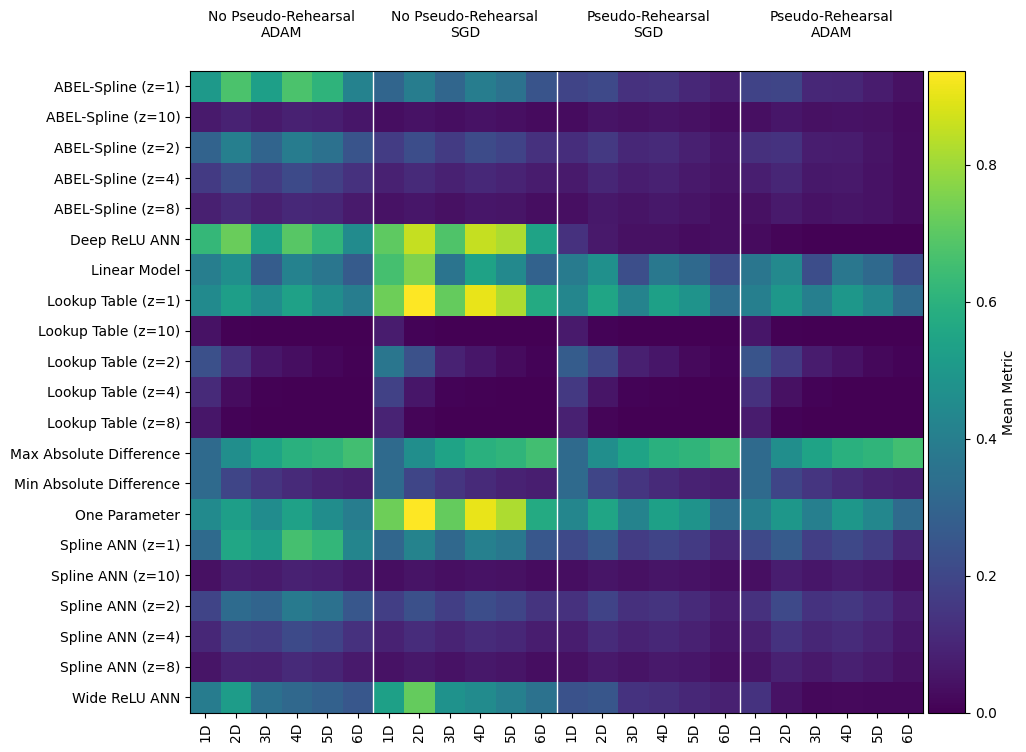

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# List of model names in the order you want them to appear on the y-axis
model_names = list(perturbation_labels_dict.values())
model_names.sort()  # Sort them alphabetically for example

# List of optimizer types and pseudo rehearsal statuses to iterate over when filling data array
optimizer_types = ['adam', 'sgd', 'sgd', 'adam']
pseudo_rehearsal_statuses = [False, False, True, True]

# Initialize 2D numpy array to hold mean values
data_array = np.zeros((len(model_names), len(optimizer_types) * 6))  # 6 for dimensions from 1 to 6

# Fill data array with mean values
for i, model_name in enumerate(model_names):
    for j, (opt_type, pseudo_status) in enumerate(zip(optimizer_types, pseudo_rehearsal_statuses)):
        for dim in range(1, 7):
            dataset_name = f"{opt_type.upper()} with {'Pseudo-Rehearsal' if pseudo_status else 'No Pseudo-Rehearsal'} in {dim}D"
            if dataset_name in means_stds and model_name in means_stds[dataset_name]:
                data_array[i, j * 6 + dim - 1] = means_stds[dataset_name][model_name]['mean']

# Create 2D imshow plot with colorbar
fig, ax = plt.subplots(figsize=(10, len(model_names)/2))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(data_array, interpolation='nearest', cmap='viridis')
cbar = fig.colorbar(im, cax=cax, orientation="vertical")

# Add label to colorbar
cbar.set_label("Mean Metric", rotation=90)

# Set model names as y tick labels
ax.set_yticks(np.arange(len(model_names)))
ax.set_yticklabels(model_names)

# Set x tick labels and draw white lines to separate different groups
x_tick_labels = []
for j in range(len(optimizer_types)):
    for dim in range(1, 7):
        x_tick_labels.append(f"{dim}D")
    if j < len(optimizer_types) - 1:
        ax.axvline(x=(j+1)*6 - 0.5, color='white', linewidth=1)
ax.set_xticks(np.arange(len(x_tick_labels)))
ax.set_xticklabels(x_tick_labels, rotation=90)

# Add text above each group of datasets indicating optimizer type and pseudo rehearsal status
for j, (opt_type, pseudo_status) in enumerate(zip(optimizer_types, pseudo_rehearsal_statuses)):
    ax.text(j * 6 + 2.5, -2.5,
            f"{'Pseudo-Rehearsal' if pseudo_status else 'No Pseudo-Rehearsal'}\n{opt_type.upper()}",
            horizontalalignment='center', verticalalignment='top')

plt.show()

In [11]:
def modelNames():

    models = ["Linear Model",
              "Wide ReLU ANN",
              "Deep ReLU ANN"
             ]
        
    for partition_num in [1,2,4,8,10]: 
        models.append(f"ABEL-Spline (z={partition_num})")
        
    for partition_num in [1,2,4,8,10]: 
        models.append(f"Spline ANN (z={partition_num})")
        
    for partition_num in [1,2,4,8,10]: 
        models.append(f"Lookup Table (z={partition_num})")

    return models

model_names = modelNames()

print(model_names)

['Linear Model', 'Wide ReLU ANN', 'Deep ReLU ANN', 'ABEL-Spline (z=1)', 'ABEL-Spline (z=2)', 'ABEL-Spline (z=4)', 'ABEL-Spline (z=8)', 'ABEL-Spline (z=10)', 'Spline ANN (z=1)', 'Spline ANN (z=2)', 'Spline ANN (z=4)', 'Spline ANN (z=8)', 'Spline ANN (z=10)', 'Lookup Table (z=1)', 'Lookup Table (z=2)', 'Lookup Table (z=4)', 'Lookup Table (z=8)', 'Lookup Table (z=10)']


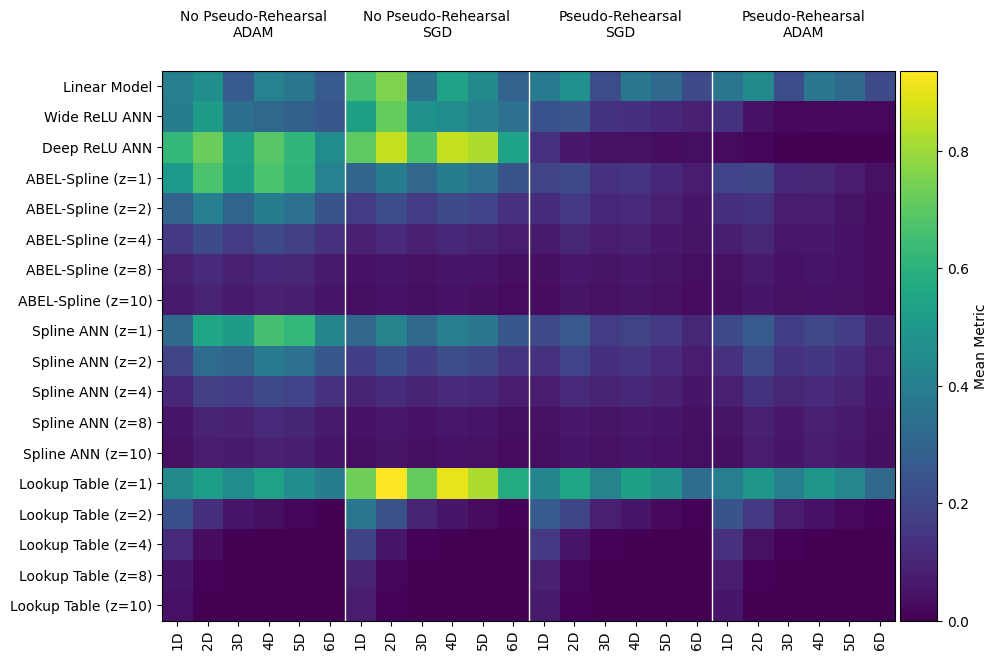

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# List of model names in the order you want them to appear on the y-axis
#model_names = list(perturbation_labels_dict.values())
#model_names.sort()  # Sort them alphabetically for example

# List of optimizer types and pseudo rehearsal statuses to iterate over when filling data array
optimizer_types = ['adam', 'sgd', 'sgd', 'adam']
pseudo_rehearsal_statuses = [False, False, True, True]

# Initialize 2D numpy array to hold mean values
data_array = np.zeros((len(model_names), len(optimizer_types) * 6))  # 6 for dimensions from 1 to 6

# Fill data array with mean values
for i, model_name in enumerate(model_names):
    for j, (opt_type, pseudo_status) in enumerate(zip(optimizer_types, pseudo_rehearsal_statuses)):
        for dim in range(1, 7):
            dataset_name = f"{opt_type.upper()} with {'Pseudo-Rehearsal' if pseudo_status else 'No Pseudo-Rehearsal'} in {dim}D"
            if dataset_name in means_stds and model_name in means_stds[dataset_name]:
                data_array[i, j * 6 + dim - 1] = means_stds[dataset_name][model_name]['mean']

# Create 2D imshow plot with colorbar
fig, ax = plt.subplots(figsize=(10, len(model_names)/2))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(data_array, interpolation='nearest', cmap='viridis')
cbar = fig.colorbar(im, cax=cax, orientation="vertical")

# Add label to colorbar
cbar.set_label("Mean Metric", rotation=90)

# Set model names as y tick labels
ax.set_yticks(np.arange(len(model_names)))
ax.set_yticklabels(model_names)

# Set x tick labels and draw white lines to separate different groups
x_tick_labels = []
for j in range(len(optimizer_types)):
    for dim in range(1, 7):
        x_tick_labels.append(f"{dim}D")
    if j < len(optimizer_types) - 1:
        ax.axvline(x=(j+1)*6 - 0.5, color='white', linewidth=1)
ax.set_xticks(np.arange(len(x_tick_labels)))
ax.set_xticklabels(x_tick_labels, rotation=90)

# Add text above each group of datasets indicating optimizer type and pseudo rehearsal status
for j, (opt_type, pseudo_status) in enumerate(zip(optimizer_types, pseudo_rehearsal_statuses)):
    ax.text(j * 6 + 2.5, -2.5,
            f"{'Pseudo-Rehearsal' if pseudo_status else 'No Pseudo-Rehearsal'}\n{opt_type.upper()}",
            horizontalalignment='center', verticalalignment='top')

plt.show()

['Linear Model', 'Wide ReLU ANN', 'Deep ReLU ANN', 'ABEL-Spline (z=1)', 'ABEL-Spline (z=2)', 'ABEL-Spline (z=4)', 'ABEL-Spline (z=8)', 'ABEL-Spline (z=10)', 'Spline ANN (z=1)', 'Spline ANN (z=2)', 'Spline ANN (z=4)', 'Spline ANN (z=8)', 'Spline ANN (z=10)', 'Lookup Table (z=1)', 'Lookup Table (z=2)', 'Lookup Table (z=4)', 'Lookup Table (z=8)', 'Lookup Table (z=10)']


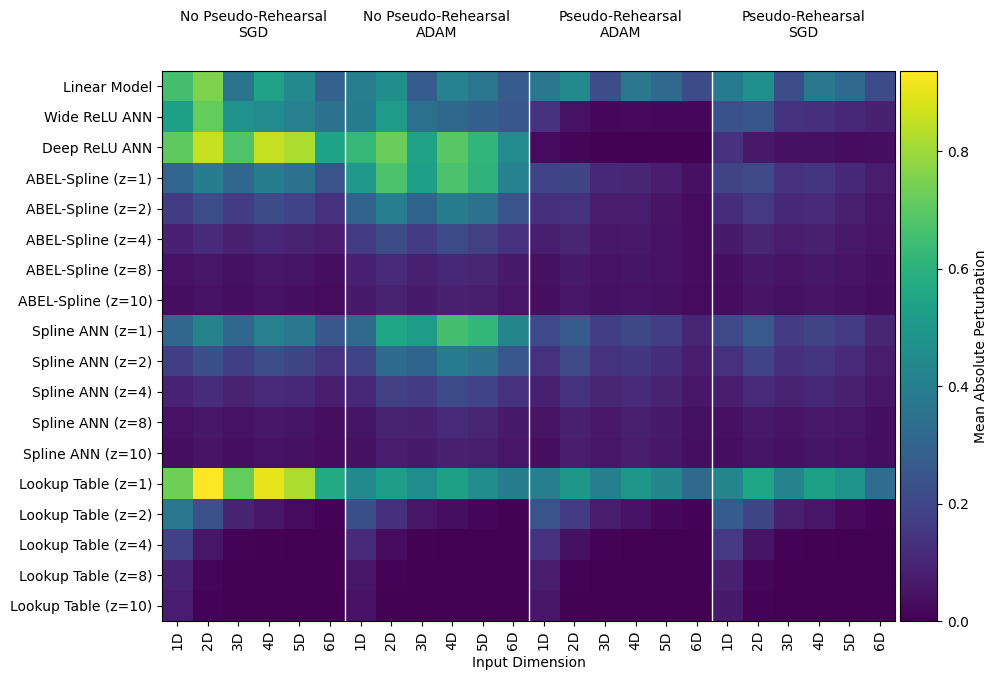

In [13]:
##################################################

def modelNames():

    models = ["Linear Model",
              "Wide ReLU ANN",
              "Deep ReLU ANN"
             ]
        
    for partition_num in [1,2,4,8,10]: 
        models.append(f"ABEL-Spline (z={partition_num})")
        
    for partition_num in [1,2,4,8,10]: 
        models.append(f"Spline ANN (z={partition_num})")
        
    for partition_num in [1,2,4,8,10]: 
        models.append(f"Lookup Table (z={partition_num})")

    return models

model_names = modelNames()

print(model_names)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# List of model names in the order you want them to appear on the y-axis
#model_names = list(perturbation_labels_dict.values())
#model_names.sort()  # Sort them alphabetically for example

# List of optimizer types and pseudo rehearsal statuses to iterate over when filling data array
optimizer_types = ['sgd', 'adam', 'adam', 'sgd']
pseudo_rehearsal_statuses = [False, False, True, True]

# Initialize 2D numpy array to hold mean values
data_array = np.zeros((len(model_names), len(optimizer_types) * 6))  # 6 for dimensions from 1 to 6

# Fill data array with mean values
for i, model_name in enumerate(model_names):
    for j, (opt_type, pseudo_status) in enumerate(zip(optimizer_types, pseudo_rehearsal_statuses)):
        for dim in range(1, 7):
            dataset_name = f"{opt_type.upper()} with {'Pseudo-Rehearsal' if pseudo_status else 'No Pseudo-Rehearsal'} in {dim}D"
            if dataset_name in means_stds and model_name in means_stds[dataset_name]:
                data_array[i, j * 6 + dim - 1] = means_stds[dataset_name][model_name]['mean']

# Create 2D imshow plot with colorbar
fig, ax = plt.subplots(figsize=(10, len(model_names)/2))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(data_array, interpolation='nearest', cmap='viridis')
cbar = fig.colorbar(im, cax=cax, orientation="vertical")

# Add label to colorbar
cbar.set_label("Mean Absolute Perturbation", rotation=90)

# Set model names as y tick labels
ax.set_yticks(np.arange(len(model_names)))
ax.set_yticklabels(model_names)

# Set x tick labels and draw white lines to separate different groups
x_tick_labels = []
for j in range(len(optimizer_types)):
    for dim in range(1, 7):
        x_tick_labels.append(f"{dim}D")
    if j < len(optimizer_types) - 1:
        ax.axvline(x=(j+1)*6 - 0.5, color='white', linewidth=1)
ax.set_xticks(np.arange(len(x_tick_labels)))
ax.set_xticklabels(x_tick_labels, rotation=90)

# Add text above each group of datasets indicating optimizer type and pseudo rehearsal status
for j, (opt_type, pseudo_status) in enumerate(zip(optimizer_types, pseudo_rehearsal_statuses)):
    ax.text(j * 6 + 2.5, -2.5,
            f"{'Pseudo-Rehearsal' if pseudo_status else 'No Pseudo-Rehearsal'}\n{opt_type.upper()}",
            horizontalalignment='center', verticalalignment='top')

# Label the x-axis
ax.set_xlabel("Input Dimension")

plt.show()

# Uncomment the following lines to save and close the figure:
# plt.savefig('heatmap.png')
# plt.close(fig)

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# List of model names in the order you want them to appear on the y-axis
#model_names = list(perturbation_labels_dict.values())
#model_names.sort()  # Sort them alphabetically for example

# List of optimizer types and pseudo rehearsal statuses to iterate over when filling data array
optimizer_types = ['adam', 'sgd', 'adam', 'sgd']
pseudo_rehearsal_statuses = [False, False, True, True]

# Initialize 2D numpy array to hold mean values
data_array = np.zeros((len(model_names), len(optimizer_types) * 6))  # 6 for dimensions from 1 to 6

# Fill data array with mean values
for i, model_name in enumerate(model_names):
    for j, (opt_type, pseudo_status) in enumerate(zip(optimizer_types, pseudo_rehearsal_statuses)):
        for dim in range(1, 7):
            dataset_name = f"{opt_type.upper()} with {'Pseudo-Rehearsal' if pseudo_status else 'No Pseudo-Rehearsal'} in {dim}D"
            if dataset_name in means_stds and model_name in means_stds[dataset_name]:
                data_array[i, j * 6 + dim - 1] = means_stds[dataset_name][model_name]['mean']

# Create 2D imshow plot with colorbar
fig, ax = plt.subplots(figsize=(10, len(model_names)/2))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(data_array, interpolation='nearest', cmap='viridis')
cbar = fig.colorbar(im, cax=cax, orientation="vertical")

# Add label to colorbar
cbar.set_label("Mean Absolute Perturbation", rotation=90)

# Set model names as y tick labels
ax.set_yticks(np.arange(len(model_names)))
ax.set_yticklabels(model_names)

# Set x tick labels and draw white lines to separate different groups
x_tick_labels = []
for j in range(len(optimizer_types)):
    for dim in range(1, 7):
        x_tick_labels.append(f"{dim}D")
    if j < len(optimizer_types) - 1:
        ax.axvline(x=(j+1)*6 - 0.5, color='white', linewidth=1)
ax.set_xticks(np.arange(len(x_tick_labels)))
ax.set_xticklabels(x_tick_labels, rotation=90)

# Add text above each group of datasets indicating optimizer type and pseudo rehearsal status
for j, (opt_type, pseudo_status) in enumerate(zip(optimizer_types, pseudo_rehearsal_statuses)):
    ax.text(j * 6 + 2.5, -1.7,
            f"{'Pseudo-Rehearsal' if pseudo_status else 'No Pseudo-Rehearsal'}\n{opt_type.upper()}",
            horizontalalignment='center', verticalalignment='top')

# Label the x-axis
ax.set_xlabel("Input Dimension")

#plt.show()
plt.savefig('perturbation_tabular_visualisation.png', dpi=300, bbox_inches='tight')
plt.close(fig)
# Uncomment the following lines to save and close the figure:
# plt.savefig('heatmap.png')
# plt.close(fig)

In [15]:
list_of_metrics = ['mean', 'std']
model_names = perturbation_labels_dict.values() # Model names from your labels dictionary
dataset_names = means_stds.keys() # Dataset names from the previously computed means_stds dictionary

# Create file
with open("latex_tables.txt", "w") as file:
    file.write("\\begin{tiny}\n")
    file.write("\\begin{longtable}{llrr}\n")
    file.write("\\caption{\\normalsize{Perturbation Data: Mean and standard deviation of metrics.}}\n")
    file.write("\\label{tab:long_table}" + "\\\\" + "\n")
    
    table_header = "\\textbf{Dataset} & \\textbf{Model} & \\textbf{Mean} & \\textbf{Standard Deviation}"
    file.write(table_header + " \\\\ \n")

    # Header to each page after first page
    file.write("\\endfirsthead\n")
    
    # For subsequent pages
    file.write("\\multicolumn{4}{c}{\\tablename\\ \\thetable{} -- Continued from previous page} \\\\\n")
    file.write(table_header + " \\\\ \n")
    
    # Add header to each subsequent page
    file.write("\\endhead\n")

    # Add footer to each page when table continues on next page
    file.write("\\multicolumn{4}{r}{Continued on next page} \\\\ \n")
    file.write("\\endfoot\n")

    # Footer for the final page of the table
    file.write("\\endlastfoot\n")

    for dataset in dataset_names:
        # Replace '_' with '\_'
        dataset_name_latex = dataset.replace("_", "\\_")

        for model in model_names:
            row = [dataset_name_latex, model]
            for metric in list_of_metrics:
                mean_or_std = means_stds[dataset][model][metric]
                row.append("$" + "{:.3f}".format(mean_or_std) +"$")
            file.write(" & ".join(row) +"\\\\"+ "\n")

    file.write("\\end{longtable}\n")
    file.write("\\end{tiny}\n")

print("Latex tables have been written to 'latex_tables.txt'")

Latex tables have been written to 'latex_tables.txt'


In [16]:
def modelNames():

    models = ["Linear Model",
              "Wide ReLU ANN",
              "Deep ReLU ANN"
             ]
        
    for partition_num in [1,2,4,8,10]: 
        models.append(f"ABEL-Spline (z={partition_num})")
        
    for partition_num in [1,2,4,8,10]: 
        models.append(f"Spline ANN (z={partition_num})")
        
    for partition_num in [1,2,4,8,10]: 
        models.append(f"Lookup Table (z={partition_num})")

    return models

model_names = modelNames()

print(model_names)

# Convert set to list and sort them for consistent order
input_dimensions = np.arange(1,7)

# Create file
with open("perturb_data_latex_tables.txt", "w") as file:
    file.write("\\begin{tiny}\n")
    file.write("\\begin{longtable}{l|l||c|c||c|c}\n")
    file.write("\\caption{\\normalsize{Perturbation Data: Mean and standard deviation of test error.}}\n")
    file.write("\\label{tab:long_table}" + "\\\\" + "\n")
    
    # Table header
    table_header = "\\textbf{Input Dimension} & \\textbf{Models} & \\multicolumn{2}{c||}{\\textbf{No Pseudo-Rehearsal}} & \\multicolumn{2}{c}{\\textbf{Pseudo-Rehearsal}} \\\\"
    sub_header = "& & \\textbf{ADAM} & \\textbf{SGD} & \\textbf{ADAM} & \\textbf{SGD}"
    file.write(table_header + " \\\\ \n")
    file.write(sub_header + " \\\\ \n")

    # Add header to each subsequent page
    file.write("\\endhead\n")

    # Footer for the final page of the table
    file.write("\\endlastfoot\n")

    for dim in input_dimensions:
        for model_name in model_names:
            row = [str(dim), model_name]
            for pseudo_rehearsal_status in [False, True]:
                for optimizer_type in ['ADAM', 'SGD']:
                    dataset_name = f"{optimizer_type} with {'Pseudo-Rehearsal' if pseudo_rehearsal_status else 'No Pseudo-Rehearsal'} in {dim}D"
                    if dataset_name not in means_stds or model_name not in means_stds[dataset_name]:
                        row.append('N/A')
                    else:
                        mean = means_stds[dataset_name][model_name]['mean']
                        std = means_stds[dataset_name][model_name]['std']
                        row.append("$" + "{:.3f}".format(mean) + "\\pm" + "{:.3f}".format(std) +"$")
            file.write(" & ".join(row) +"\\\\"+ "\n")

    file.write("\\end{longtable}\n")
    file.write("\\end{tiny}\n")

print("Latex tables have been written to 'perturb_data_latex_tables.txt'")

['Linear Model', 'Wide ReLU ANN', 'Deep ReLU ANN', 'ABEL-Spline (z=1)', 'ABEL-Spline (z=2)', 'ABEL-Spline (z=4)', 'ABEL-Spline (z=8)', 'ABEL-Spline (z=10)', 'Spline ANN (z=1)', 'Spline ANN (z=2)', 'Spline ANN (z=4)', 'Spline ANN (z=8)', 'Spline ANN (z=10)', 'Lookup Table (z=1)', 'Lookup Table (z=2)', 'Lookup Table (z=4)', 'Lookup Table (z=8)', 'Lookup Table (z=10)']
Latex tables have been written to 'perturb_data_latex_tables.txt'


In [18]:
# Create file
with open("latex_tables.txt", "w") as file:
    file.write("\\begin{tiny}\n")
    file.write("\\begin{longtable}{lrccccc}\n")
    file.write("\\caption{\\normalsize{Mean and standard deviation of perturbation data}}\n")
    file.write("\\label{tab:perturbation_data}" + "\\\\" + "\n")
    
    # Table header
    table_header = "\\textbf{$n$} & \\textbf{Model} & \\textbf{NPR with ADAM} & \\textbf{NPR with SGD} & \\textbf{PR with ADAM} & \\textbf{PR with SGD}"
    file.write(table_header + " \\\\ \n")

    # Header to each page after first page
    file.write("\\endfirsthead\n")
    
    # For subsequent pages
    file.write("\\multicolumn{6}{c}{\\tablename\\ \\thetable{} -- Continued from previous page} \\\\\n")
    file.write(table_header + " \\\\ \n")
    
    # Add header to each subsequent page
    file.write("\\endhead\n")

    # Add footer to each page when table continues on next page
    file.write("\\multicolumn{6}{r}{Continued on next page} \\\\ \n")
    file.write("\\endfoot\n")

    # Footer for the final page of the table
    file.write("\\endlastfoot\n")

    for dim in range(1, 7):
        for model_name in model_names:
            row = [str(dim), model_name]
            for pseudo_rehearsal_status in [False, True]:
                for optimizer_type in ['adam', 'sgd']:
                    dataset_name = f"{optimizer_type.upper()} with {'Pseudo-Rehearsal' if pseudo_rehearsal_status else 'No Pseudo-Rehearsal'} in {dim}D"
                    mean = means_stds[dataset_name][model_name]['mean']
                    std = means_stds[dataset_name][model_name]['std']
                    row.append("$" + "{:.3f}".format(mean) + "\\pm" + "{:.3f}".format(std) +"$")
            file.write(" & ".join(row) +"\\\\"+ "\n")

    file.write("\\end{longtable}\n")
    file.write("\\end{tiny}\n")

print("Latex tables have been written to 'latex_tables.txt'")

Latex tables have been written to 'latex_tables.txt'


Latex tables have been written to 'latex_tables.txt'
